In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#from keras import layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from keras.models import Sequential

from PIL import Image
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [ ]:
DATA_DIR = '/kaggle/input/chest-xray-pneumonia/chest_xray'

print(f"files in current directory: {os.listdir()}")

print(f"\nsubdirectories within '{DATA_DIR}' dir: {os.listdir(DATA_DIR)}")

files in current directory: ['.config', 'sample_data']

subdirectories within '/kaggle/input/chest-xray-pneumonia/chest_xray' dir: ['chest_xray', '__MACOSX', 'val', 'test', 'train']


In [ ]:
train_normal_dir = os.path.join(DATA_DIR, 'train/NORMAL')
train_pneumonia_dir = os.path.join(DATA_DIR, 'train/PNEUMONIA')

val_normal_dir = os.path.join(DATA_DIR, 'val/NORMAL')
val_pneumonia_dir = os.path.join(DATA_DIR, 'val/PNEUMONIA')

print(f"For training:")
print(f"There are {len(os.listdir(train_normal_dir))} images of normals.")
print(f"There are {len(os.listdir(train_pneumonia_dir))} images of pneumonia.")

print(f"\nFor Validation:")
print(f"There are {len(os.listdir(val_normal_dir))} images of normals.")
print(f"There are {len(os.listdir(val_pneumonia_dir))} images of pneumonia.")

For training:
There are 1341 images of normals.
There are 3875 images of pneumonia.

For Validation:
There are 8 images of normals.
There are 8 images of pneumonia.


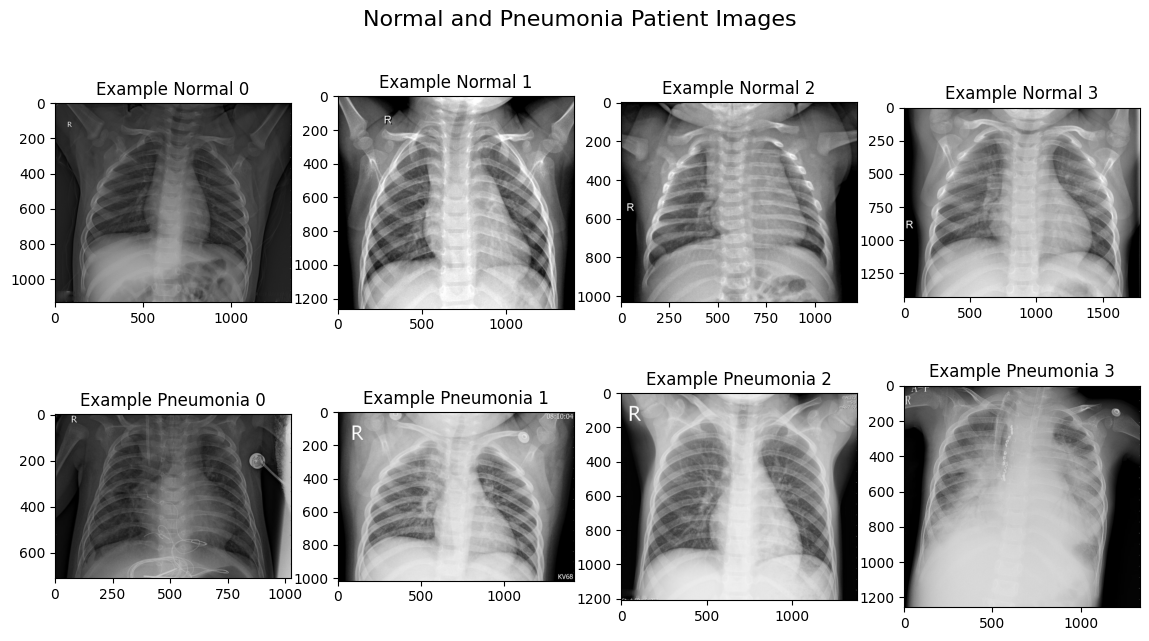

In [ ]:
normal_filenames = [os.path.join(train_normal_dir, filename) for filename in os.listdir(train_normal_dir)]
pneumonia_filenames = [os.path.join(train_pneumonia_dir, filename) for filename in os.listdir(train_pneumonia_dir)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Normal and Pneumonia Patient Images', fontsize=16)

for i, normal_image in enumerate(normal_filenames[:4]):
    img = tf.keras.utils.load_img(normal_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Example Normal {i}")

for i, pneumonia_image in enumerate(pneumonia_filenames[:4]):
    img = tf.keras.utils.load_img(pneumonia_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Example Pneumonia {i}")

plt.show()


# Task
Apply CNN with Adam optimizer and early stopping, then save the model.

## Prepare the data

### Subtask:
Create data generators for training and validation sets using `ImageDataGenerator`.


**Reasoning**:
Create data generators for training and validation sets using ImageDataGenerator including data augmentation for the training set and only rescaling for the validation set.



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Instantiate ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

# Instantiate ImageDataGenerator for validation data without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

# Create validation data generator
val_generator = val_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Build the cnn model

### Subtask:
Define the architecture of the convolutional neural network using `Sequential`.


**Reasoning**:
Define the CNN model architecture using Sequential as per the instructions.



In [ ]:
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

## Compile the model

### Subtask:
Configure the model for training using `compile`, specifying the optimizer, loss function, and metrics.


**Reasoning**:
Compile the defined model using the specified optimizer, loss function, and metrics.



In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Set up callbacks

### Subtask:
Define `EarlyStopping` and `ModelCheckpoint` callbacks to monitor training and save the best model.


**Reasoning**:
Define EarlyStopping and ModelCheckpoint callbacks to monitor training and save the best model as specified in the instructions.



In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Create a list of callbacks
callbacks_list = [early_stopping, model_checkpoint]

## Train the model

### Subtask:
Train the compiled model using the data generators and callbacks.


**Reasoning**:
Train the compiled model using the data generators and callbacks as per the instructions.



In [ ]:
# Calculate steps per epoch
steps_per_epoch = train_generator.samples // train_generator.batch_size

# Calculate validation steps
validation_steps = val_generator.samples // val_generator.batch_size

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=8, # Set a suitable number of epochs
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 98s 558ms/step - accuracy: 0.7502 - loss: 0.7983 - val_accuracy: 0.6875 - val_loss: 0.6119
Epoch 2/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 121s 459ms/step - accuracy: 0.8864 - loss: 0.2772 - val_accuracy: 0.6875 - val_loss: 0.8683
Epoch 3/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 450ms/step - accuracy: 0.9107 - loss: 0.2210 - val_accuracy: 0.6875 - val_loss: 0.6841
Epoch 4/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 433ms/step - accuracy: 0.9196 - loss: 0.1978 - val_accuracy: 0.6250 - val_loss: 0.9972
Epoch 5/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 423ms/step - accuracy: 0.9218 - loss: 0.1996 - val_accuracy: 0.6875 - val_loss: 0.7320
Epoch 6/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 434ms/step - accuracy: 0.9327 - loss: 0.1785 - val_accuracy: 0.8750 - val_loss: 0.4010
Epoch 7/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 435ms/step - accuracy: 0.9431 - loss: 0.1522 - val_accuracy: 0.6250 - val_loss: 0.7668
Epoch 8/8
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 433ms/step - accuracy: 0.9409 - loss: 0.1532 -

## Evaluate the model

### Subtask:
Evaluate the trained model using the validation data generator.

**Reasoning**:
Evaluate the trained model on the validation set using the `evaluate` method to assess its performance.

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.8750 - loss: 0.4010
Validation Loss: 0.4010
Validation Accuracy: 0.8750


## Save the model

### Subtask:
Save the trained model in a suitable format for deployment.

In [ ]:
# Save the trained model
model.save('pneumonia_cnn_model.keras')

print("Model saved successfully.")

Model saved successfully.


# Task
Create a Streamlit application in Colab that loads a previously saved CNN model, provides an interface for prediction, and run it using a public URL.

## Install streamlit

### Subtask:
Install the Streamlit library.


**Reasoning**:
Install the streamlit library using pip.

